In [8]:
import optuna
from tqdm import tqdm
import logging
import sys
import torch
import os
from datetime import datetime
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torch.utils.data
#from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset, DataLoader
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('high')
print(device)

cuda


### Define Dataset function

In [9]:
class GalaxyJungle(Dataset):
    
    #the init function initializes the directory containing the image,
    #the annotations file,
    #and both transforms
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None, is_rgb=False):
        self.rgb = is_rgb
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    #returns number of samples in the dataset
    def __len__(self):
        return (self.img_labels).shape[0]

    #loads a sample from the dataset
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0])) + '.jpg'
        #retrieves the image
        image = Image.open(img_path)
        if not self.rgb: image = image.convert('L')
        #retrieves corresponding label
        label = self.img_labels.iloc[idx, 1:]
        #if possible, transform the image and the label into a tensor.
        if self.transform:
            image = self.transform(image).type(torch.float16)
        label = torch.tensor(label.values, dtype=torch.float16)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, self.img_labels.iloc[idx, 0]
    

transfs = transforms.Compose([
    transforms.ToTensor(), # Riscala le immagini tra 0 e 1
    transforms.CenterCrop(324),
    transforms.Resize(128),
    # sarebbe interessante implementare un random crop prima del center crop per decentrare un poco le immagini????
    transforms.RandomHorizontalFlip(), # horizontal flip
    transforms.RandomVerticalFlip(), # vertical flip
              #CROP
    ]) #transforms.compose per fare una pipe di transformazioni

## NEURAL NETWORK

In [10]:
class GalaxyNet(nn.Module):
    def __init__(self, n_conv_layers, num_filters, num_neurons, activation, is_rgb=False, verbose=False):
        super().__init__()
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation
        
        self.num_convs = n_conv_layers


        stride = 2
        kernel_size = 3
        kernel_size_pool = 2
        
        ## convolutional layers
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, num_filters[0], kernel_size=kernel_size, stride=stride, bias=False),
            self.activation(),
            nn.BatchNorm2d(num_filters[0]),
            nn.MaxPool2d(kernel_size=kernel_size_pool)
            )
        output_size = (input_size - kernel_size + stride) // (stride*kernel_size_pool)

        if verbose: print('output size after first conv layer: ', output_size)

        for i in range(1,n_conv_layers):
            self.convs.append(nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=kernel_size, stride=stride, bias=False))
            self.convs.append(self.activation())
            self.convs.append(nn.BatchNorm2d(num_filters[i]))
            self.convs.append(nn.MaxPool2d(kernel_size=kernel_size_pool))

            output_size = (output_size - kernel_size + stride) // (stride*kernel_size_pool) #padding 0, dilation = 1
            if verbose: 
                if i != n_conv_layers - 1: print('output size after conv layer {}: '.format(i), output_size)
                else: 
                    print('output size of the last conv layer: ', output_size)
                    print('len self convs: ',len(self.convs))
        if output_size in (0, -1): output_size = 1
        print(output_size)
        
        #self.convs.append(nn.dropout(p= value)) ## to be added in the future to test claims of BatchnOrm paper
        
        self.out_feature = num_filters[-1] *output_size * output_size # output size of the last conv layer, should be 38
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.out_feature, num_neurons),
            self.activation(),
            nn.Linear(num_neurons, num_labels)
            )
        
        self.init_weights()


    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        # x = nn.Sigmoid()(x)
        return x


        

    def init_weights(self):
        if self.activation == nn.ReLU: # perchè kaiming normal e non uniform??1
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        print(a)
        for i in range(0, self.num_convs*4, 4): nn.init.kaiming_normal_(self.convs[i].weight, a=a, nonlinearity=nonlin)
        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)
        return print('weights initialized with {}'.format(self.activation))         
        

    

    
    def log_the_loss(self, item,epoch=False): # per avere una history della loss???
        verbose=False
        train = self.__getstate__()['training']
        if verbose: print(train)
        if epoch and train:
            self.loss_dict['epoch'].append(item) ### get state of the model so you can ditch the validation parameter
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item

## TRAINING + VALIDATION

In [11]:
def one_epoch_train(model, train_loader, optimizer, loss_function, verbose=False):
    running_loss = 0
    last_loss = 0
    model.train()
    for i, data in tqdm(enumerate(train_loader)):
        inputs,labels, _ = data
        inputs,labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs) #, activation=F.relu)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimizer.step() # fa update del parameter
        RMSEloss = np.sqrt(loss.item())
        running_loss += RMSEloss
        if verbose and i%10 ==0: print(f'Batch {i+1}/{len(train_loader)} - Loss: {RMSEloss:.3f}')

        model.log_the_loss(RMSEloss, epoch=False)
    epochmean_loss = running_loss / len(train_loader)
    print(f'\nLoss: {epochmean_loss:.3f}')
    model.log_the_loss(epochmean_loss, epoch=True)
    last_loss = RMSEloss
    print(f"Last loss: {last_loss:.3f}")
    return epochmean_loss



def one_epoch_eval(model, test_loader, loss_function, verbose=False):
    model.eval()
    running_validation_loss = 0.
   
    with torch.no_grad(): # deactivates gradient evaluation
        for i, vdata in tqdm(enumerate(test_loader)):
            inputs,labels, _ = vdata
            inputs,labels= inputs.to(device), labels.to(device)
            with torch.autocast('cuda'):
                outputs = model(inputs)#, activation=F.relu)
                loss = loss_function(outputs ,labels)
            RMSEloss = np.sqrt(loss.item())
            running_validation_loss +=RMSEloss
            model.log_the_loss(RMSEloss,epoch=False)
    mean_vloss=model.log_the_loss(running_validation_loss/len(test_loader),epoch=True)
    if verbose: print(f"Validation Loss: {mean_vloss:.3f}\n---")
    return mean_vloss

## OPTUNA


100008


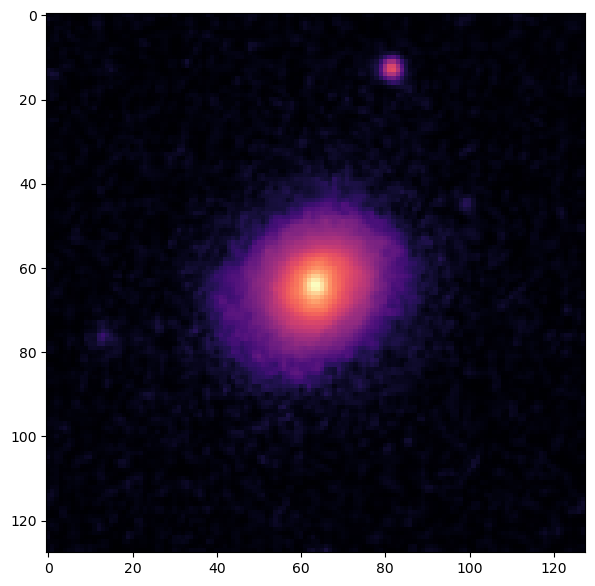

In [12]:
DS = GalaxyJungle('../data/training/training_solutions_rev1.csv', '../data/training/', transfs)
training, test, true_test = random_split(DS, [.65, .2, .15])

img, lab, indx = DS.__getitem__(0)
#print(lab)
#print(img)         #3D TENSOR    
if DS.rgb:
    fig, ax = plt.subplots(1,3, figsize=(24,7))
    color = ['Reds', 'Greens', 'Blues']
    for i,j in enumerate(img):
        ax[i].imshow(j, cmap=color[i])
else:
    fig, ax = plt.subplots(1,1, figsize=(24,7))
    ax.imshow(img[0], cmap='magma')
print(indx)


In [13]:
DS = GalaxyJungle('../data/training/training_solutions_rev1.csv', '../data/training/', transfs)
training, test, true_test = random_split(DS, [.65, .2, .15])

def objective(trial:optuna.Trial):
   
    ## Hyperspace
    num_conv_layers = 1
    #qui tuniamo il numero di filri, per layer più profondi ci vogliono più filtri (64-28 è consigliato per pattern astratti e combinazioni, mentre fino a 32 per dettagli locali) quindi proviamo (VGG usa fino a 512 per esempio).
    num_filters = [int(trial.suggest_int("num_filters_"+str(i), 6, 64, step=8)) for i in range(num_conv_layers)]
    ## abbiamo numneurons1 e numn neurons2,se mettiamo un grid sampler o un random sampler con num_neurons e basta penso che lui provi diverse combinazioni
    num_neurons = trial.suggest_int("num_neurons", 10, 70, step=10) 
    ### abbiamo chiamato mode l'activation function nell'initialization dei pesi o la chiamiamo activation o FUNZIONEDIATTIVAZIONE così optuna poi iniializza in base a quello
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    optimizer = trial.suggest_categorical("optimizer", ["Adam", "SGD", "AdamW"]) #AdamW è suggerito per CNN.
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True) #log true cerca i valori in scala logaritmica
    momentum = trial.suggest_float("momentum", 0.5, 0.9, step=0.1) #per SGD
    # batch size da tunare?
    batch_size = 32
    epochs = 10
    loss_function = nn.MSELoss()
    
    ##### Training phase
    
    
    
    train_loader = DataLoader(training, batch_size=batch_size, shuffle=True, num_workers=8)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=8) 
    activation = getattr(nn, activation)
    model = GalaxyNet(num_conv_layers, num_filters, num_neurons, activation).half().to(device)
    if optimizer == 'SGD': optimizer = getattr(optim, optimizer)(model.parameters(), lr=learning_rate, momentum = momentum)
    else: optimizer = getattr(optim, optimizer)(model.parameters(), lr=learning_rate)

    
    for epoch in range(0, epochs):
        print(f'Training epoch {epoch}')
        one_epoch_train(model, train_loader, optimizer, loss_function, verbose=False)
        print(f'Validation epoch {epoch}')
        epoch_last_val_loss = one_epoch_eval(model, test_loader, loss_function, verbose=True)
        trial.report(epoch_last_val_loss,epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    
    score = epoch_last_val_loss
    return score

In [14]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "pinned"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(objective, n_trials=5)

[I 2025-05-20 16:01:48,155] Using an existing study with name 'pinned' instead of creating a new one.


Using an existing study with name 'pinned' instead of creating a new one.
Using an existing study with name 'pinned' instead of creating a new one.
31
0
weights initialized with <class 'torch.nn.modules.activation.ReLU'>
Training epoch 0


/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [6, 64] and step=8, but the range is not divisible by `step`. It will be replaced by [6, 62].
  warnings.warn(
1251it [00:38, 32.80it/s]


Loss: 0.215
Last loss: 0.206
Validation epoch 0



385it [00:12, 30.00it/s]


Validation Loss: 0.180
---
Training epoch 1


1251it [00:40, 30.58it/s]


Loss: 0.175
Last loss: 0.176
Validation epoch 1



213it [00:06, 31.56it/s]
[W 2025-05-20 16:03:27,824] Trial 16 failed with parameters: {'num_filters_0': 62, 'num_neurons': 10, 'activation': 'ReLU', 'optimizer': 'SGD', 'learning_rate': 0.0046291797819334145, 'momentum': 0.7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_15438/395478366.py", line 38, in objective
    epoch_last_val_loss = one_epoch_eval(model, test_loader, loss_function, verbose=True)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_15438/2591818165.py", line 36, in one_epoch_eval
    outputs = model(inputs)#, activation=F.relu)
              ^^^^^^^^^^^^^
  File "/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/torch/nn/modules/mod

Trial 16 failed with parameters: {'num_filters_0': 62, 'num_neurons': 10, 'activation': 'ReLU', 'optimizer': 'SGD', 'learning_rate': 0.0046291797819334145, 'momentum': 0.7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_15438/395478366.py", line 38, in objective
    epoch_last_val_loss = one_epoch_eval(model, test_loader, loss_function, verbose=True)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_15438/2591818165.py", line 36, in one_epoch_eval
    outputs = model(inputs)#, activation=F.relu)
              ^^^^^^^^^^^^^
  File "/home/teobaldo/miniconda3/envs/jungle/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return s

[W 2025-05-20 16:03:27,827] Trial 16 failed with value None.


Trial 16 failed with value None.
Trial 16 failed with value None.


KeyboardInterrupt: 